# Recreate Figure 5 from Kay, 2012 (COSP vs. CAM4/5/6)

#### With updated observations (2007-2015)

### Add paths to run locally or off Cheyenne or Casper 
(what is the difference between these two again?)

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis/Common/')
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims,
    to_png
    )

from cloud_metric import Cloud_Metric
from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Check running location and adjust working directory appropriately.

In [2]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    
elif 'casper' in host: # Check if running on NIRD through the Jupyter Hub
    print('Running through CISL Casper')
    
elif 'r6i6' in host: # Check if running on NIRD through the Jupyter Hub
    print('Running through CISL Cheyenne')
    
else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)



Running on crhtc62, attempting to mount ns9600k/jonahks/ from NIRD


FileNotFoundError: [Errno 2] No such file or directory: '/home/jonahks/drivemount/'

### Find the files

In [3]:
# case_dir = '/glade/scratch/jonahshaw/archive/Kay_COSP_2012/'
case_dir = '/glade/u/home/jonahshaw/w/archive/Kay_COSP_2012/'

In [4]:
os.chdir(case_dir)

In [5]:
os.listdir()

['f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1',
 'cam5_1deg_release_amip',
 'cam4_1deg_release_amip']

### Load post-processed CAM4 and CAM5 files into a cloud metric

In [11]:
fig5metric = Cloud_Metric(case_dir)
fig5metric.add_case('cam4_1deg_release_amip',label='CAM4')
fig5metric.add_case('cam5_1deg_release_amip',label='CAM5')
fig5metric.add_case(case='f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1',path='/glade/p/cesm/pcwg/jenkay/COSP/cesm21/',label='CAM6 CMIP6 AMIP')

Loading GOCCP data...done.
Loading CALIOP SLFs...Could not load cloudtop CALIOP slfs from caliop_olimpia/ct_slf_olimpia/cloudtop_slfs.nc
Loading CERES-EBAF fluxes...done.
Loading ISCCP cloud total...done.
Loading MISR cloud histograms...done.
Loading MODIS cloud histograms...done.
Processed timeseries directory found for cam4_1deg_release_amip. Will load data as required.
cam4_1deg_release_amip load successfully.
Processed timeseries directory found for cam5_1deg_release_amip. Will load data as required.
cam5_1deg_release_amip load successfully.
Processed timeseries directory found for f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1. Will load data as required.
f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1 load successfully.


In [7]:
cam4metric = Cloud_Metric(case_dir)
cam4metric.add_case('cam4_1deg_release_amip',label='CAM4')

cam5metric = Cloud_Metric(case_dir)
cam5metric.add_case('cam5_1deg_release_amip',label='CAM5')

cam6metric = Cloud_Metric('/glade/p/cesm/pcwg/jenkay/COSP/cesm21/')
cam6metric.add_case(case='f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1',path='/glade/p/cesm/pcwg/jenkay/COSP/cesm21/',label='CAM6 CMIP6 AMIP')

# cam6metric.add_case('cesm2p1_FHIST_COSP2_lidarphasefix',label='CESM2.1/CAM6 FAMIP \n Lidar Phase Fix')

Loading GOCCP data...done.
Loading CALIOP SLFs...Could not load cloudtop CALIOP slfs from caliop_olimpia/ct_slf_olimpia/cloudtop_slfs.nc
Loading CERES-EBAF fluxes...done.
Loading ISCCP cloud total...done.
Loading MISR cloud histograms...done.
Loading MODIS cloud histograms...done.
Processed timeseries directory found for cam4_1deg_release_amip. Will load data as required.
cam4_1deg_release_amip load successfully.
Loading GOCCP data...done.
Loading CALIOP SLFs...Could not load cloudtop CALIOP slfs from caliop_olimpia/ct_slf_olimpia/cloudtop_slfs.nc
Loading CERES-EBAF fluxes...done.
Loading ISCCP cloud total...done.
Loading MISR cloud histograms...done.
Loading MODIS cloud histograms...done.
Processed timeseries directory found for cam5_1deg_release_amip. Will load data as required.
cam5_1deg_release_amip load successfully.
Loading GOCCP data...done.
Loading CALIOP SLFs...Could not load cloudtop CALIOP slfs from caliop_olimpia/ct_slf_olimpia/cloudtop_slfs.nc
Loading CERES-EBAF fluxes...d

### Only use observations from 2007-2015

In [8]:
cam6metric.goccp_data = cam6metric.goccp_data.sel(time=slice('2007-01-01','2015-12-31'))
cam5metric.goccp_data = cam5metric.goccp_data.sel(time=slice('2007-01-01','2015-12-31'))
cam4metric.goccp_data = cam4metric.goccp_data.sel(time=slice('2007-01-01','2015-12-31'))

In [ ]:
# cldlow1 = cam4metric.plot2D('CLDLOW_CAL',bias=True,contour=True,levels=np.linspace(-50,50,21),extend='neither',projection='Robinson')

In [ ]:
# to_png(fig,"kay2012_fig5_py")

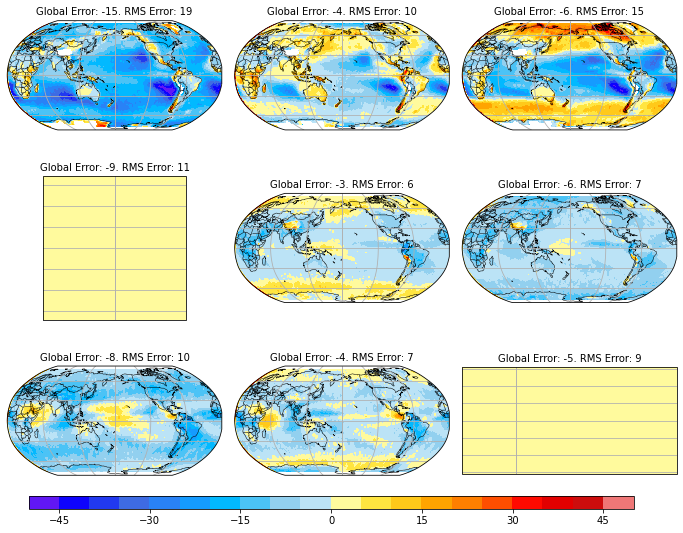

In [10]:
# fig,axs = plt.subplots(nrows=2,ncols=2,sharey='row')
fig, axs = sp_map(nrows=3, ncols=3, projection=ccrs.Robinson(central_longitude=180))#, figsize=[15,2*(len(self.cases))])

fig.set_figheight(9)
fig.set_figwidth(12)
# fig.set_dpi(200)

axs = axs.flat
fig.subplots_adjust(wspace=0.06)

cldlow1 = cam4metric.plot2D('CLDLOW_CAL',ax=[axs[0]],bias=True,contour=True,label=False,
                            levels=np.linspace(-50,50,21),extend='neither',projection='Robinson')
cldlow2 = cam5metric.plot2D('CLDLOW_CAL',ax=[axs[1]],bias=True,contour=True,label=False,
                            levels=np.linspace(-50,50,21),extend='neither',projection='Robinson')
cldlow3 = cam6metric.plot2D('CLDLOW_CAL',ax=[axs[2]],bias=True,contour=True,label=False,
                            levels=np.linspace(-50,50,21),extend='neither',projection='Robinson')

cldmed1 = cam4metric.plot2D('CLDMED_CAL',ax=[axs[3]],bias=True,contour=True,label=False,
                            levels=np.linspace(-50,50,21),extend='neither',projection='Robinson')
cldmed2 = cam5metric.plot2D('CLDMED_CAL',ax=[axs[4]],bias=True,contour=True,label=False,
                            levels=np.linspace(-50,50,21),extend='neither',projection='Robinson')
cldmed3 = cam6metric.plot2D('CLDMED_CAL',ax=[axs[5]],bias=True,contour=True,label=False,
                            levels=np.linspace(-50,50,21),extend='neither',projection='Robinson')

cldhgh1 = cam4metric.plot2D('CLDHGH_CAL',ax=[axs[6]],bias=True,contour=True,label=False,
                            levels=np.linspace(-50,50,21),extend='neither',projection='Robinson')
cldhgh2 = cam5metric.plot2D('CLDHGH_CAL',ax=[axs[7]],bias=True,contour=True,label=False,
                            levels=np.linspace(-50,50,21),extend='neither',projection='Robinson')
cldhgh3 = cam6metric.plot2D('CLDHGH_CAL',ax=[axs[8]],bias=True,contour=True,label=False,
                            levels=np.linspace(-50,50,21),extend='neither',projection='Robinson')

a = np.array([[-50,50]])

img = plt.imshow(a, cmap=cmaps.ncl_default)

# cbar_ax = fig.add_axes([0.92, 0.15, 0.05, 0.70])
cbar_axh = fig.add_axes([0.15, 0.10, 0.70, 0.02])

fig.colorbar(cldhgh2[1], cax=cbar_axh,orientation='horizontal')

### I have no explanation for this legal pad error.

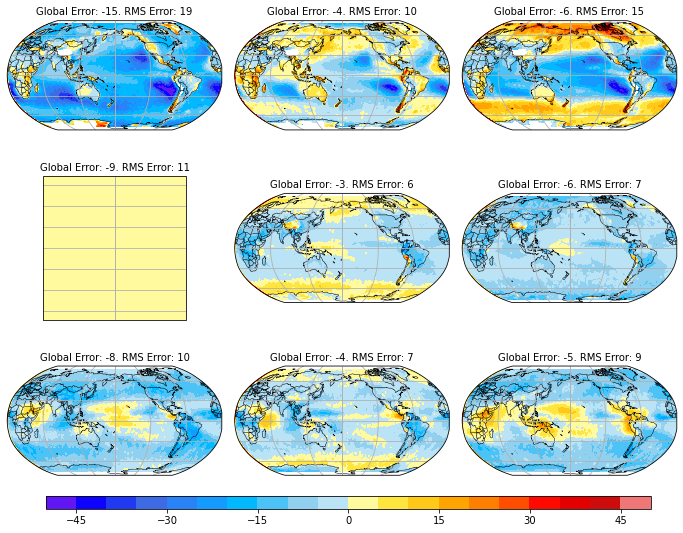

In [25]:
fig, axs = sp_map(nrows=3, ncols=3, projection=ccrs.Robinson(central_longitude=180))#, figsize=[15,2*(len(self.cases))])

fig.set_figheight(9)
fig.set_figwidth(12)
# fig.set_dpi(200)

# axs = axs.flat
axs0 = axs[0,:]
axs1 = axs[1,:]
axs2 = axs[2,:]

fig.subplots_adjust(wspace=0.06)

cldlow = fig5metric.plot2D('CLDLOW_CAL',bias=True,contour=True,label=False,ax=axs0,
                  levels=np.linspace(-50,50,21),extend='neither',projection='Robinson')

cldmed = fig5metric.plot2D('CLDMED_CAL',bias=True,contour=True,label=False,ax=axs1,
                  levels=np.linspace(-50,50,21),extend='neither',projection='Robinson')

cldhgh = fig5metric.plot2D('CLDHGH_CAL',bias=True,contour=True,label=False,ax=axs2,
                  levels=np.linspace(-50,50,21),extend='neither',projection='Robinson')

cbar_axh = fig.add_axes([0.17, 0.10, 0.70, 0.02])

fig.colorbar(cldhgh[1], cax=cbar_axh,orientation='horizontal')

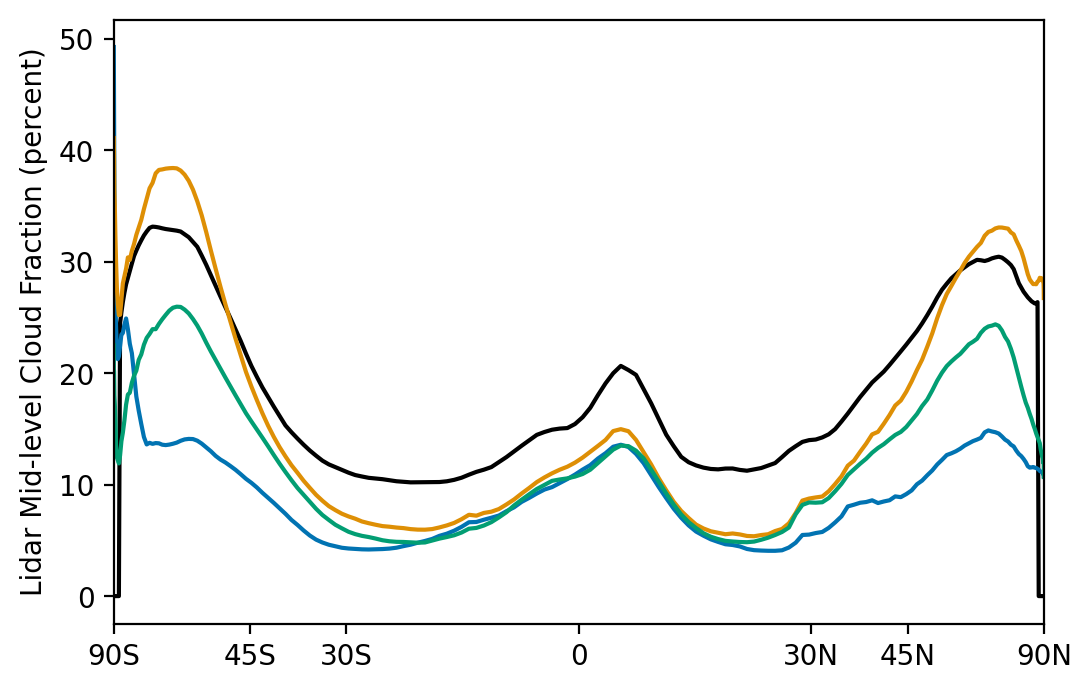

In [32]:
medcld = fig5metric.plot1D('CLDMED_CAL')

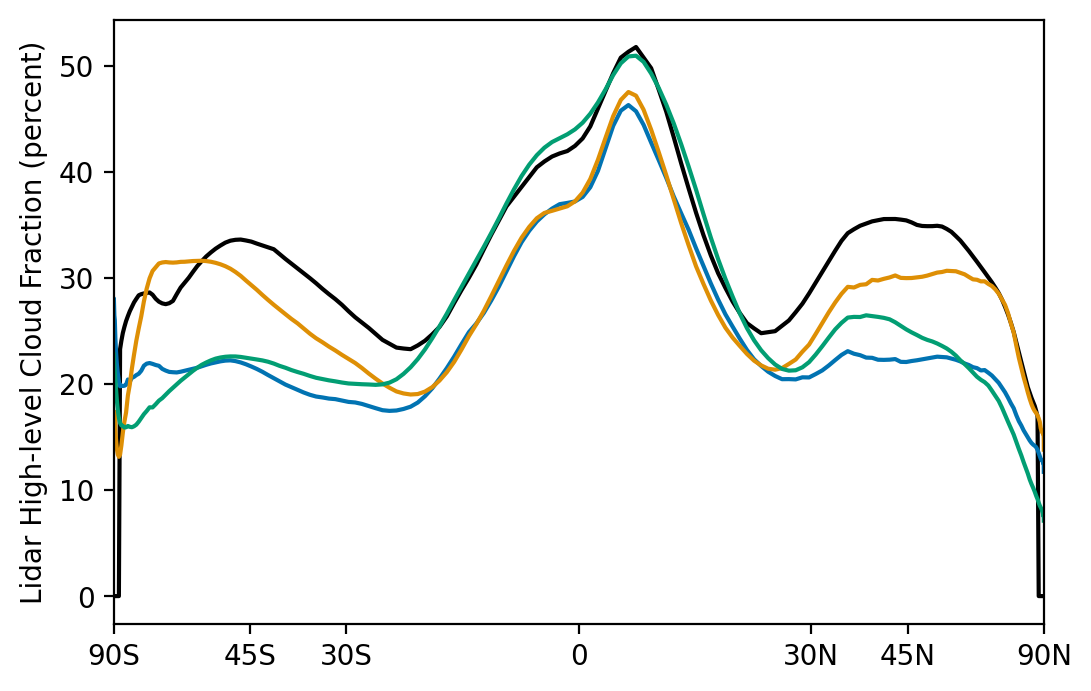

In [33]:
hghcld = fig5metric.plot1D('CLDHGH_CAL')

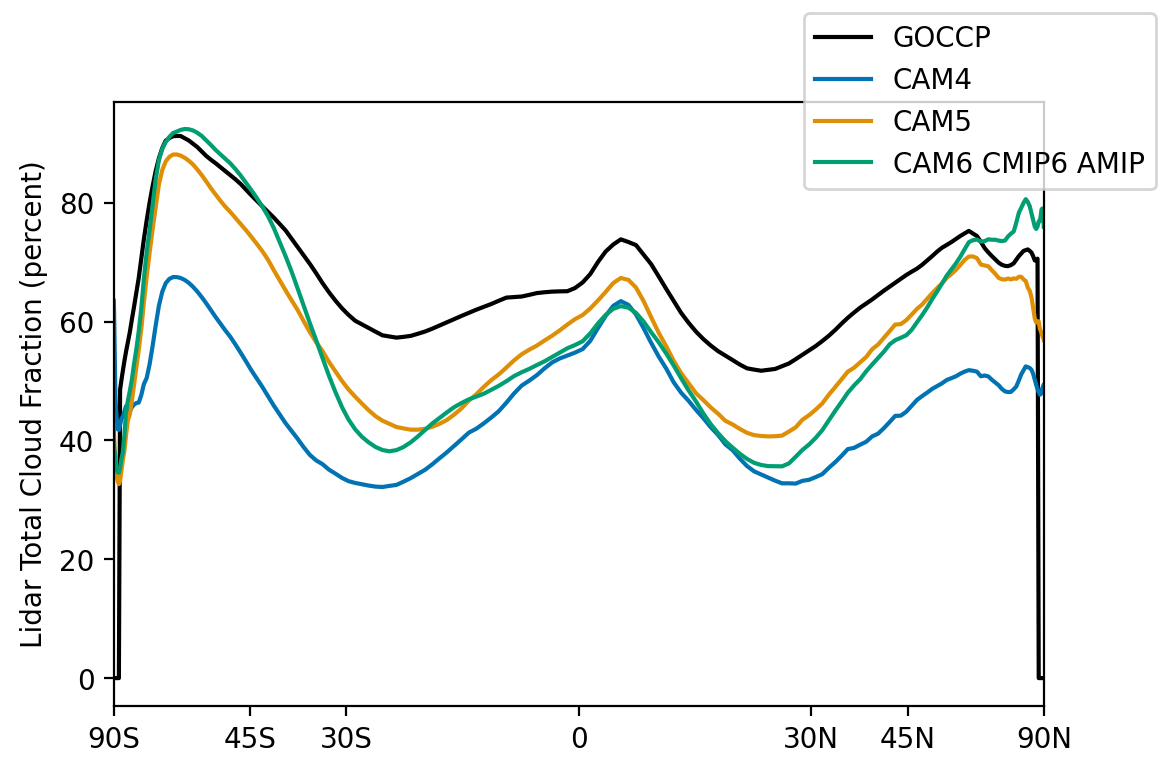

In [30]:
totcld = fig5metric.plot1D('CLDTOT_CAL')

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'robust', 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide

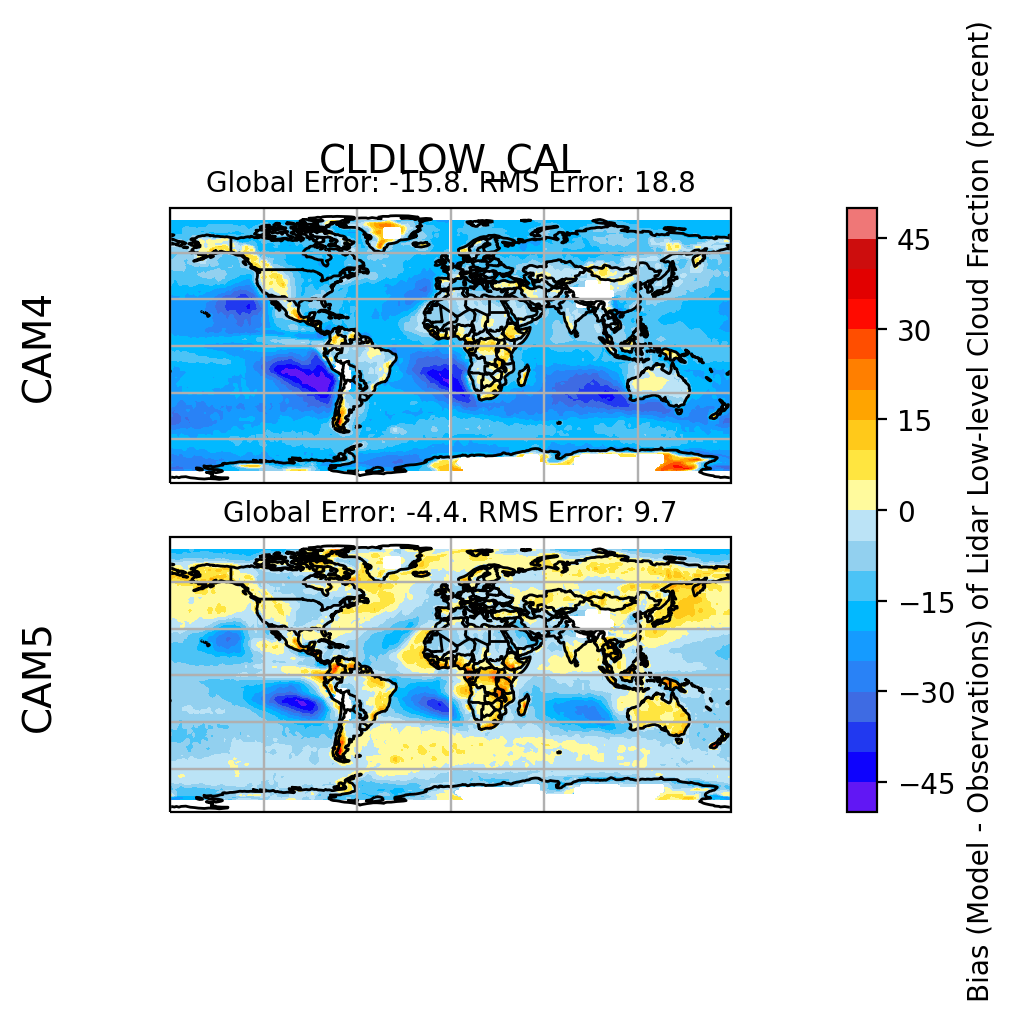

In [21]:
cldlow = fig5metric.plot2D('CLDLOW_CAL',layers=False,bias=True,contour=True,levels=np.linspace(-50,50,21),extend='neither')

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'robust', 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide

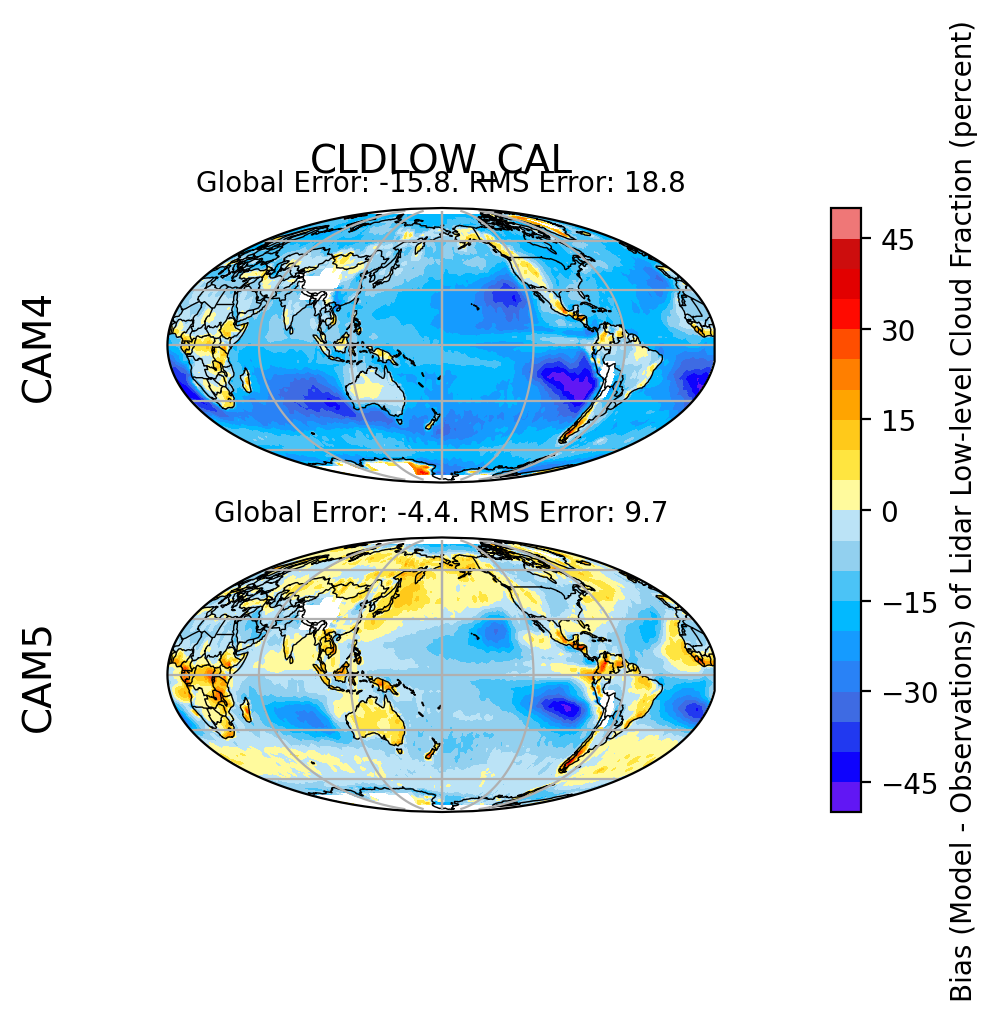

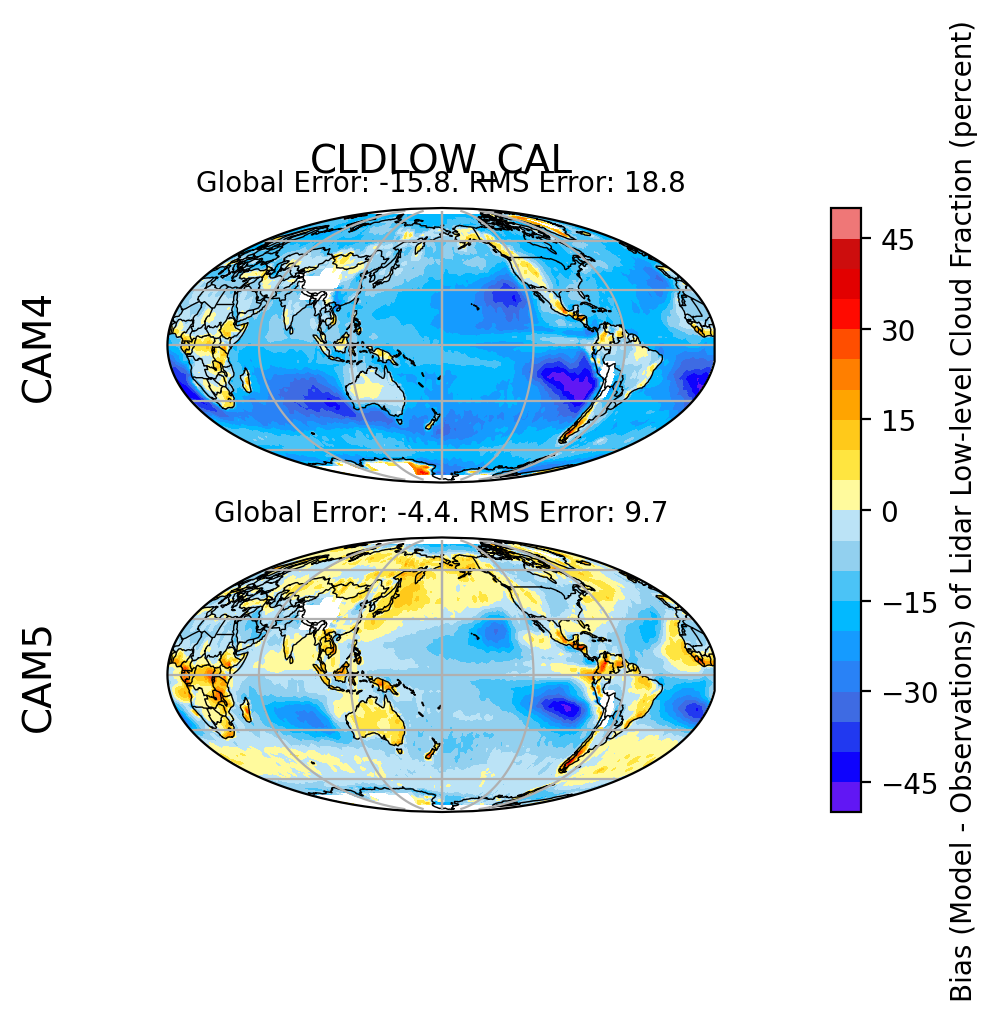

In [8]:
fig5metric.plot2D('CLDLOW_CAL',layers=False,bias=True,contour=True,levels=np.linspace(-50,50,21),extend='neither',projection='Mollweide')

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlab

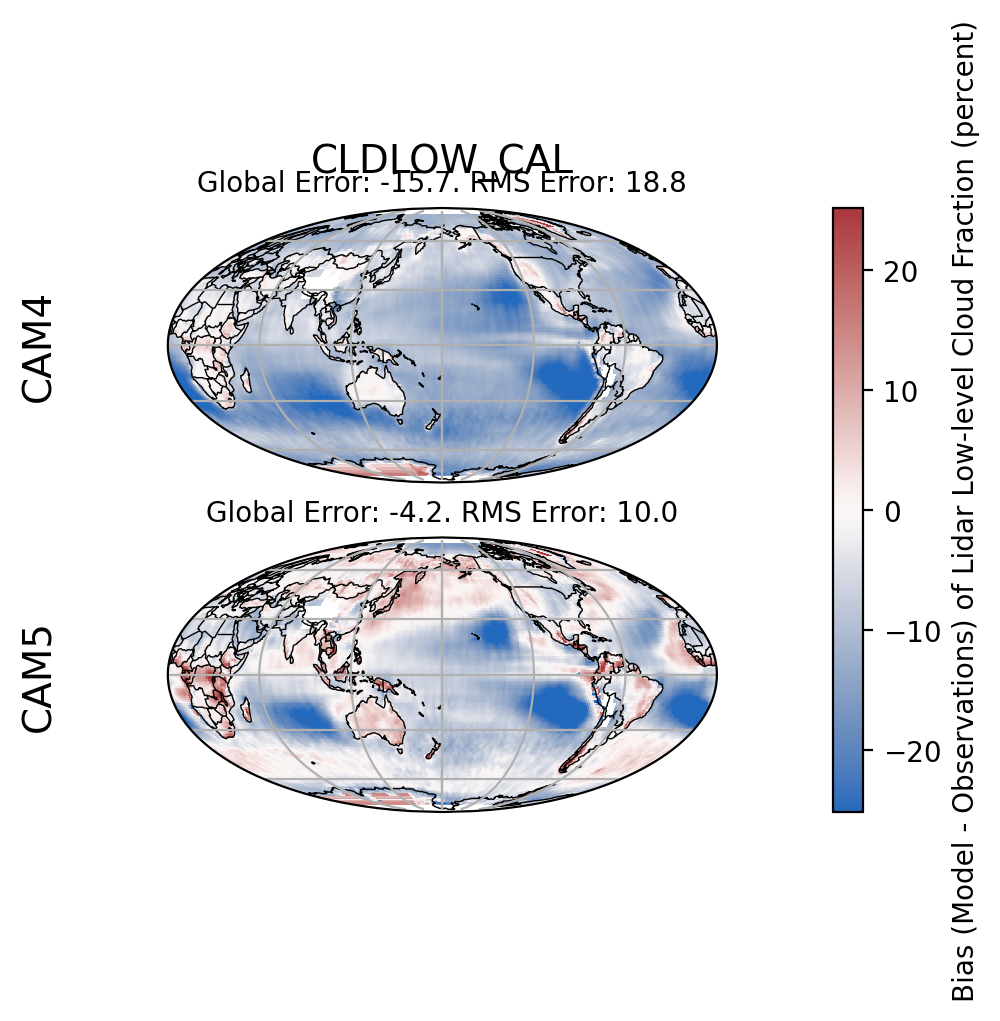

Error in callback <function flush_figures at 0x2ac822f087a0> (for post_execute):


KeyboardInterrupt: 

In [9]:
fig5metric.plot2D('CLDLOW_CAL',layers=False,bias=True,contour=False,projection='Mollweide')#,levels=np.linspace(-50,50,21),extend='neither',projection='Mollweide')

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'robust', 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy

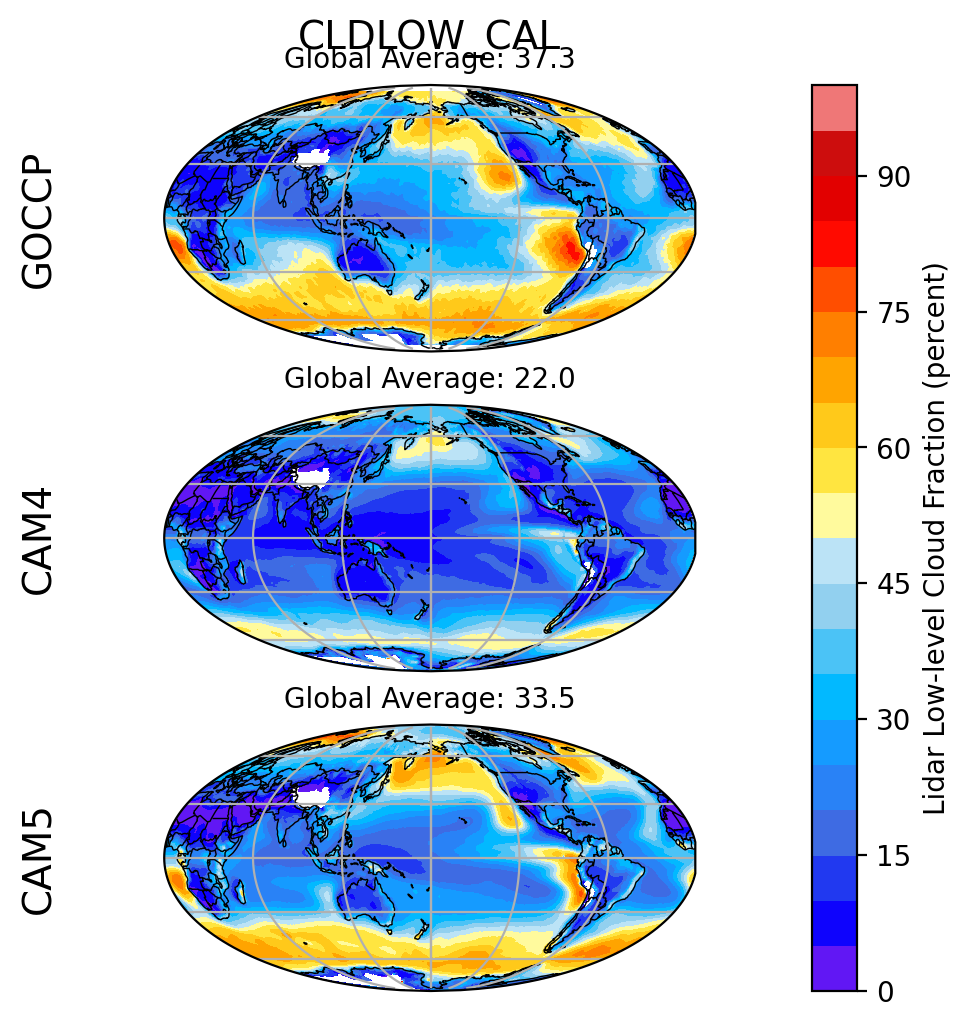

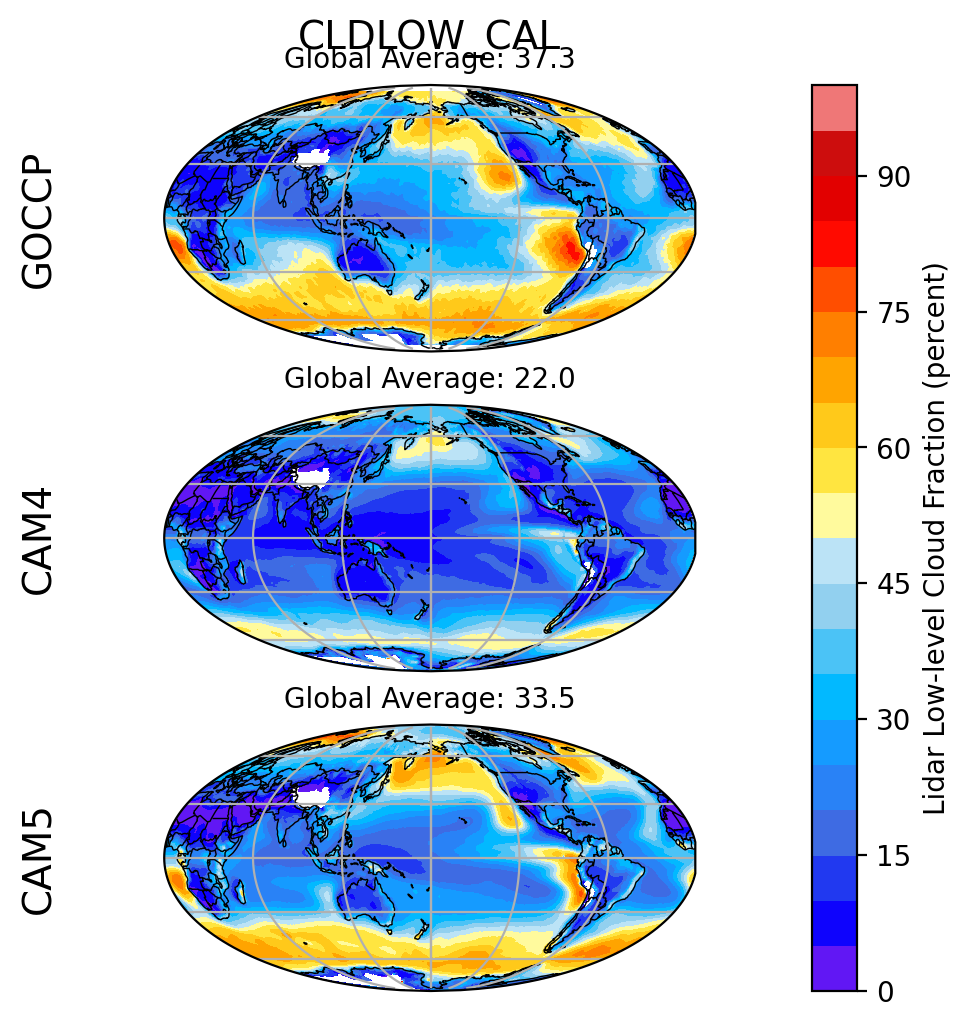

In [14]:
fig5metric.plot2D('CLDLOW_CAL',layers=False,bias=False,contour=True,levels=np.linspace(0,100,21),extend='neither',projection='Robinson')

### Old stuff

In [3]:
new_metric.colors[0:3] = ['blue','cornflowerblue','red','maroon','salmon'] # Set colors simply
# new_metric.colors[0:3] = ['blue','red','salmon'] # Set colors simply
new_metric.styles[0:] = ['dashed','dotted','dashed','dashed','dotted']
new_metric.add_case('cesmle_B1850_COSP1p4_PCWG3',label='CESM1 B1850',path='cesm112lens/runs_cesm1_1_2_LENS_n21/')
new_metric.add_case('cesm112LENS_FAMIPC5.f09_f09.001_cosp1.4_opaq_prec',label='CESM1.2/CAM5 FAMIP',path='cesm112lens/runs_cesm1_1_2_LENS_n16_cosp1.4_opaq_prec/')
new_metric.add_case('cesm2p1_B1850_COSP2_PCWG2',label='CESM2.1 B1850')
new_metric.add_case('cesm2p1_B1850_COSP2_lidarphasefix',label='CESM2.1 B1850 \n Lidar Phase Fix')
new_metric.add_case('cesm2p1_FHIST_COSP2_lidarphasefix',label='CESM2.1/CAM6 FAMIP \n Lidar Phase Fix')

Loading GOCCP data...done.
Loading CALIOP SLFs...Could not load cloudtop CALIOP slfs from caliop_olimpia/ct_slf_olimpia/cloudtop_slfs.nc
Loading CERES-EBAF fluxes...Failed to load CERES-EBAF data.


AttributeError: 'Cloud_Metric' object has no attribute 'styles'

In [ ]:
output_dir = '/glade/u/home/jonahshaw/figures/'
case_dir = '/glade/p/cesm/pcwg/jenkay/COSP/cesm21/' 

# Check that each important directory can be accessed:    
access_paths = os.path.exists(output_dir) and os.path.exists(case_dir) #and os.path.exists(conv_dir)
print('Can access all directory paths:', access_paths)

model_dir = '/glade/p/cesm/pcwg/jenkay/COSP/'
os.chdir(model_dir)

model_dir = '/glade/p/cesm/pcwg/jenkay/COSP/'
os.chdir(model_dir)

model_dir = '/mnt/mcc-ns9600k/jonahks/'
os.chdir(model_dir)